### Notebook for downloading and preprocessing the ACSIncome dataset using FolkTables

In [1]:
# required modules (skip if already installed)
if False:
    !pip install folktables

In [2]:
# global imports
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# folktables module
from folktables import ACSDataSource, ACSIncome

In [3]:
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
          'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
          'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
          'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
          'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
data = dict()
for s in states:
    data[s] = data_source.get_data(states=[s], download=True)
    data[s]['STATE'] = s

In [20]:
ACSIncome_categories = {
    "COW": {
        1: (
            "Employee of a private for-profit company or"
            "business, or of an individual, for wages,"
            "salary, or commissions"
        ),
        2: (
            "Employee of a private not-for-profit, tax-exempt,"
            "or charitable organization"
        ),
        3: "Local government employee (city, county, etc.)",
        4: "State government employee",
        5: "Federal government employee",
        6: (
            "Self-employed in own not incorporated business,"
            "professional practice, or farm"
        ),
        7: (
            "Self-employed in own incorporated business,"
            "professional practice or farm"
        ),
        8: "Working without pay in family business or farm",
        9: "Unemployed and last worked 5 years ago or earlier or never worked",
    },
    "SCHL": {
        1: "No schooling completed",
        2: "Nursery school, preschool",
        3: "Kindergarten",
        4: "Grade 1",
        5: "Grade 2",
        6: "Grade 3",
        7: "Grade 4",
        8: "Grade 5",
        9: "Grade 6",
        10: "Grade 7",
        11: "Grade 8",
        12: "Grade 9",
        13: "Grade 10",
        14: "Grade 11",
        15: "12th grade - no diploma",
        16: "Regular high school diploma",
        17: "GED or alternative credential",
        18: "Some college, but less than 1 year",
        19: "1 or more years of college credit, no degree",
        20: "Associate's degree",
        21: "Bachelor's degree",
        22: "Master's degree",
        23: "Professional degree beyond a bachelor's degree",
        24: "Doctorate degree",
    },
    "MAR": {
        1: "Married",
        2: "Widowed",
        3: "Divorced",
        4: "Separated",
        5: "Never married or under 15 years old",
    },
    "SEX": {1: "Male", 2: "Female"},
    "RAC1P": {
        1: "White alone",
        2: "Black or African American alone",
        3: "American Indian alone",
        4: "Alaska Native alone",
        5: (
            "American Indian and Alaska Native tribes specified;"
            "or American Indian or Alaska Native,"
            "not specified and no other"
        ),
        6: "Asian alone",
        7: "Native Hawaiian and Other Pacific Islander alone",
        8: "Some Other Race alone",
        9: "Two or More Races",
    },
}

In [21]:
# Merge all states
df = None
for i, s in enumerate(states):
    features, labels, _ = ACSIncome.df_to_pandas(data[s])
    features['STATE'] = i
    features['class'] = labels.astype(int)
    df = pd.concat([df, features], axis=0).reset_index(drop=True) if df is not None else features
del df["RELP"]
# decode class and STATE
ACSIncome_categories["class"] = {0: "<=50K", 1: ">50K"}
ACSIncome_categories["STATE"] = {i:s for i, s in enumerate(states)}
# set types
continuous = ['AGEP', 'WKHP']
df[continuous] = df[continuous].astype(int)
nominal = ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'SEX', 'RAC1P', 'STATE', 'class']
df[nominal] = df[nominal].astype(int).astype('category')
# binning of AGEP
df["AGEPgroup"] = pd.cut(df["AGEP"], bins=[16, 31, 41, 51, 61, 1000], labels=range(5))
ACSIncome_categories["AGEPgroup"] = { i:s for i, s in enumerate(["16-30", "31-40", "41-50", "51-60", ">60"]) }
# grouping of POBP and OCCP - see https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2016-2020.pdf
df["OCCPgroup"] = pd.cut(df["OCCP"], bins=[0, 441, 751, 961, 1241, 1561, 1981, 2061, 2181, 2556, 2921, 3551, 3656, 3961, 4161,
                                     4256, 4656, 4966, 5941, 6131, 6766, 6951, 7641, 8991, 9761, 9831, 10000], labels=range(26))
ACSIncome_categories["OCCPgroup"] = { i:s for i, s in enumerate(["MGR", "BUS", "FIN", "CMM", "ENG", "SCI", "CMS", "LGL", "EDU", "ENT", "MED", "HLS", "PRT", "EAT",
                           "CLN", "PRS", "SAL", "OFF", "FFF", "CON", "EXT", "RPR", "PRD", "TRN", "MIL", "Unp, no exp, never worked"]) }
df["POBPgroup"] = pd.cut(df["POBP"], bins=[0, 99, 199, 299, 399, 499, 599], labels=range(6))
ACSIncome_categories["POBPgroup"] = { i:s for i, s in enumerate(["US", "Europe", "Asia", "Americas", "Africa", "Australia"]) }
# binning of WKHP
df["WKHPgroup"] = pd.cut(df["WKHP"], bins=[0, 11, 21, 31, 41, 101], labels=range(5))
ACSIncome_categories["WKHPgroup"] = { i:s for i, s in enumerate(["0-10", "11-20", "21-30", "31-40", ">40"]) }

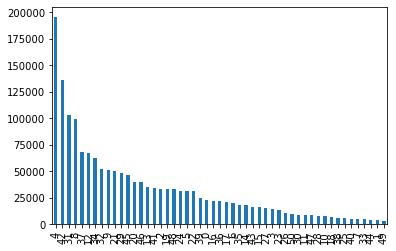

In [22]:
df["STATE"].value_counts().plot(kind='bar')
plt.show()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664500 entries, 0 to 1664499
Data columns (total 15 columns):
 #   Column     Non-Null Count    Dtype   
---  ------     --------------    -----   
 0   AGEP       1664500 non-null  int32   
 1   COW        1664500 non-null  category
 2   SCHL       1664500 non-null  category
 3   MAR        1664500 non-null  category
 4   OCCP       1664500 non-null  category
 5   POBP       1664500 non-null  category
 6   WKHP       1664500 non-null  int32   
 7   SEX        1664500 non-null  category
 8   RAC1P      1664500 non-null  category
 9   STATE      1664500 non-null  category
 10  class      1664500 non-null  category
 11  AGEPgroup  1664500 non-null  category
 12  OCCPgroup  1664500 non-null  category
 13  POBPgroup  1664500 non-null  category
 14  WKHPgroup  1664500 non-null  category
dtypes: category(13), int32(2)
memory usage: 36.5 MB


In [24]:
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,class,AGEPgroup,OCCPgroup,POBPgroup,WKHPgroup
0,18,1,18,5,4720,13,21,2,2,0,0,0,16,0,1
1,53,5,17,5,3605,18,40,1,1,0,0,3,11,0,3
2,41,1,16,5,7330,1,40,1,1,0,0,1,21,0,3
3,18,6,18,5,2722,1,2,2,1,0,0,0,9,0,0
4,21,5,19,5,3870,12,50,1,1,0,0,0,12,0,4


In [25]:
# Save df and decoders
pickle.dump([df, ACSIncome_categories], open('../data/ACSIncome.pckl', 'wb'))